# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

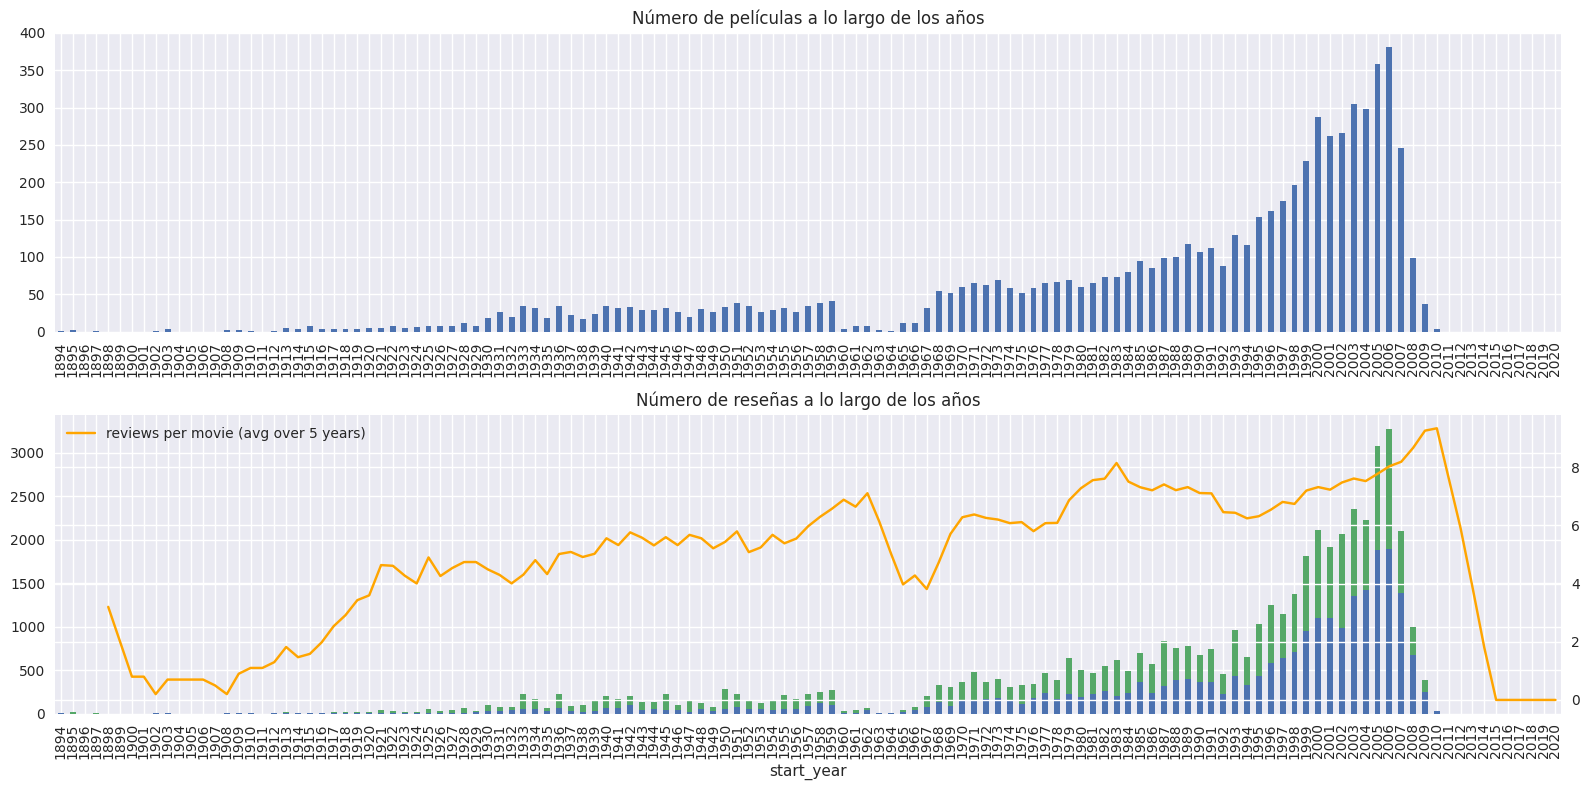

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

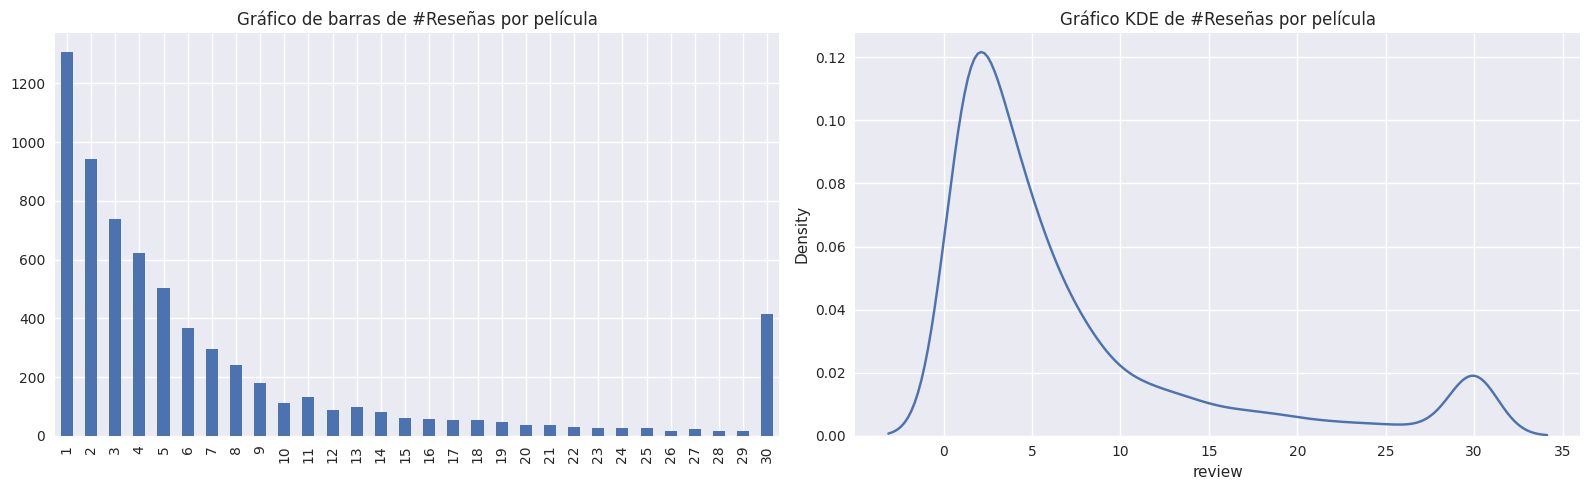

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [7]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

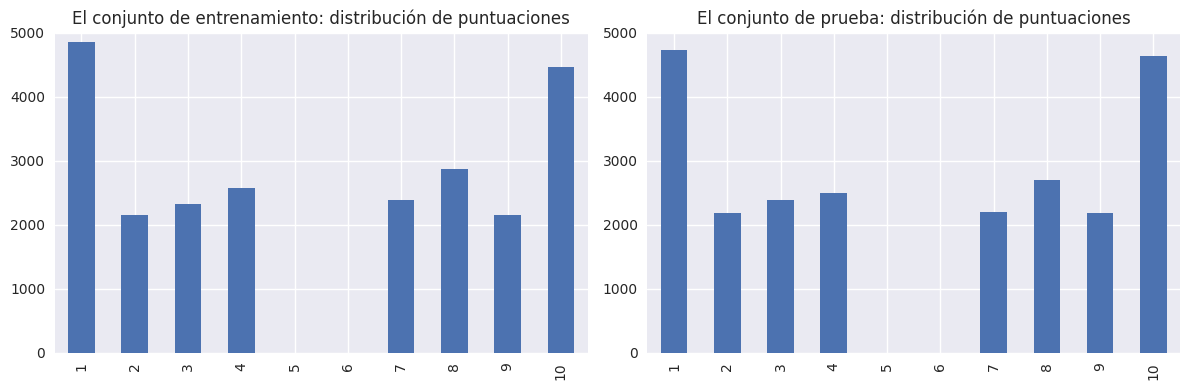

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


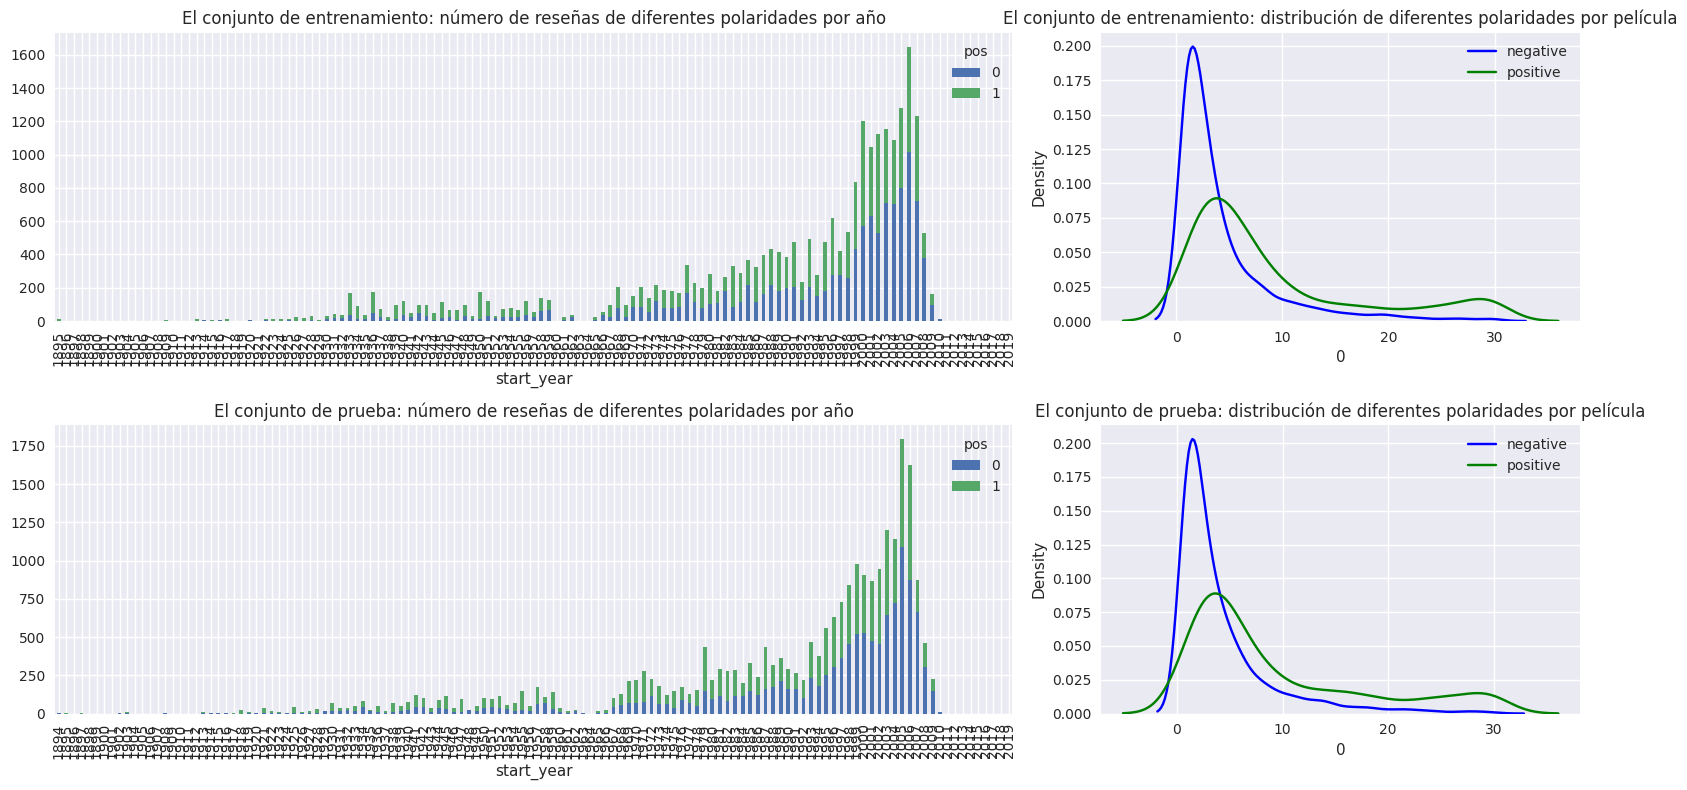

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [10]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [11]:
import re

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)            # eliminar dígitos
    text = re.sub(r'[^\w\s]', '', text)         # eliminar signos de puntuación
    text = text.strip()                         # quitar espacios al inicio y final
    return text
    
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [12]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

In [14]:
# Creamos el DummyClassifier con estrategia “most_frequent” (siempre predice la clase más frecuente)
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)

# El DummyClassifier no utiliza características reales, pero exige que X tenga la misma longitud que y.
# Podemos pasar la columna 'review_norm' (o incluso un array de ceros); el clasificador ignorará los valores:
X_train_dummy = df_reviews_train['review_norm'].values.reshape(-1, 1)
y_train = train_target

# Ajustamos el modelo constante
dummy_clf.fit(X_train_dummy, y_train)

# Predecimos en el conjunto de prueba
X_test_dummy = df_reviews_test['review_norm'].values.reshape(-1, 1)
y_test = test_target
y_pred_dummy = dummy_clf.predict(X_test_dummy)

# Evaluamos el desempeño del modelo constante
print(classification_report(y_test, y_pred_dummy, target_names=['negativo', 'positivo']))

              precision    recall  f1-score   support

    negativo       0.50      1.00      0.67     11803
    positivo       0.00      0.00      0.00     11732

    accuracy                           0.50     23535
   macro avg       0.25      0.50      0.33     23535
weighted avg       0.25      0.50      0.34     23535



/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [15]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [16]:
# Descargar stopwords si no están disponibles
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

tfidf_vect = TfidfVectorizer(
    stop_words=stop_words,
    max_df=0.95,
    min_df=5
)

# Generar las matrices TF-IDF
train_features_1 = tfidf_vect.fit_transform(df_reviews_train['review_norm'])
test_features_1  = tfidf_vect.transform(df_reviews_test['review_norm'])

# Definir el modelo
model_1 = LogisticRegression(max_iter=1000, random_state=42)

model_1.fit(train_features_1, train_target)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LogisticRegression(max_iter=1000, random_state=42)

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


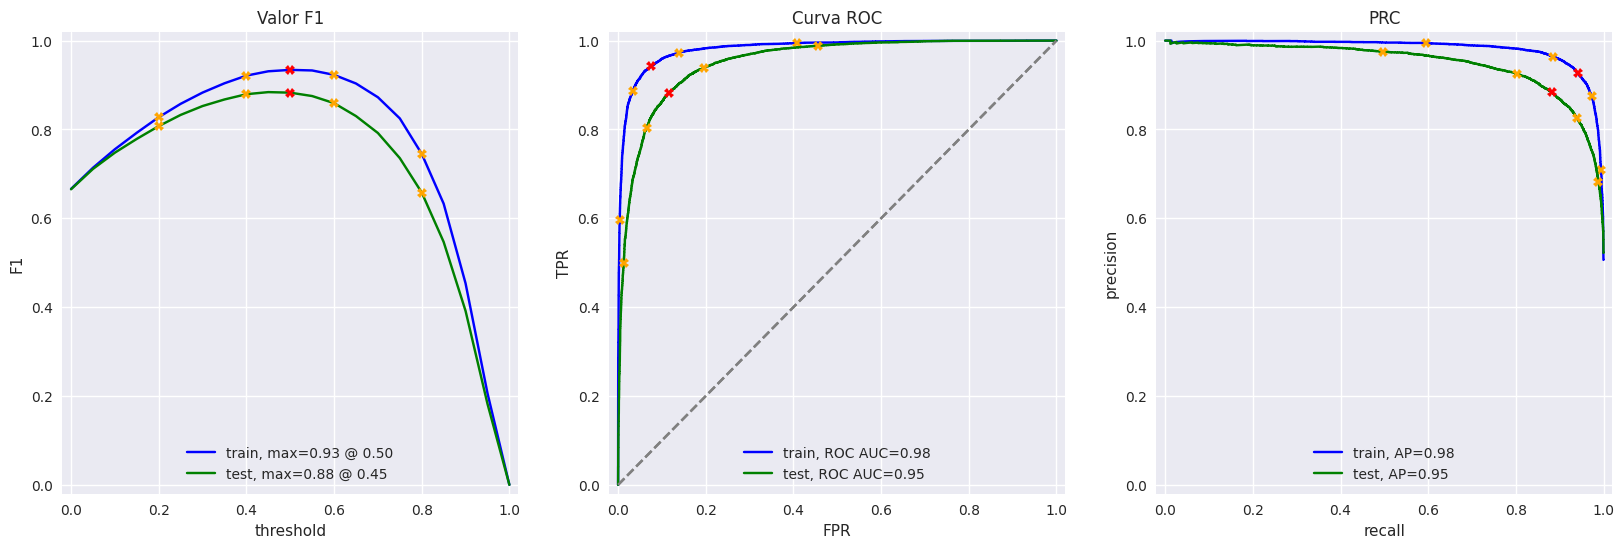

In [17]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [18]:
# Tuve que reducir en un 30% el muestreo de datos para poder procesar la información

Tamaño original train: (23796, 18)
Tamaño reducido train: (7139, 18)
Tamaño original test: (23535, 18)
Tamaño reducido test: (7061, 18)
Procesado chunk 0 a 400 de 7139
Procesado chunk 400 a 800 de 7139
Procesado chunk 800 a 1200 de 7139
Procesado chunk 1200 a 1600 de 7139
Procesado chunk 1600 a 2000 de 7139
Procesado chunk 2000 a 2400 de 7139
Procesado chunk 2400 a 2800 de 7139
Procesado chunk 2800 a 3200 de 7139
Procesado chunk 3200 a 3600 de 7139
Procesado chunk 3600 a 4000 de 7139
Procesado chunk 4000 a 4400 de 7139
Procesado chunk 4400 a 4800 de 7139
Procesado chunk 4800 a 5200 de 7139
Procesado chunk 5200 a 5600 de 7139
Procesado chunk 5600 a 6000 de 7139
Procesado chunk 6000 a 6400 de 7139
Procesado chunk 6400 a 6800 de 7139
Procesado chunk 6800 a 7139 de 7139
Procesado chunk 0 a 400 de 7061
Procesado chunk 400 a 800 de 7061
Procesado chunk 800 a 1200 de 7061
Procesado chunk 1200 a 1600 de 7061
Procesado chunk 1600 a 2000 de 7061
Procesado chunk 2000 a 2400 de 7061
Procesado chun

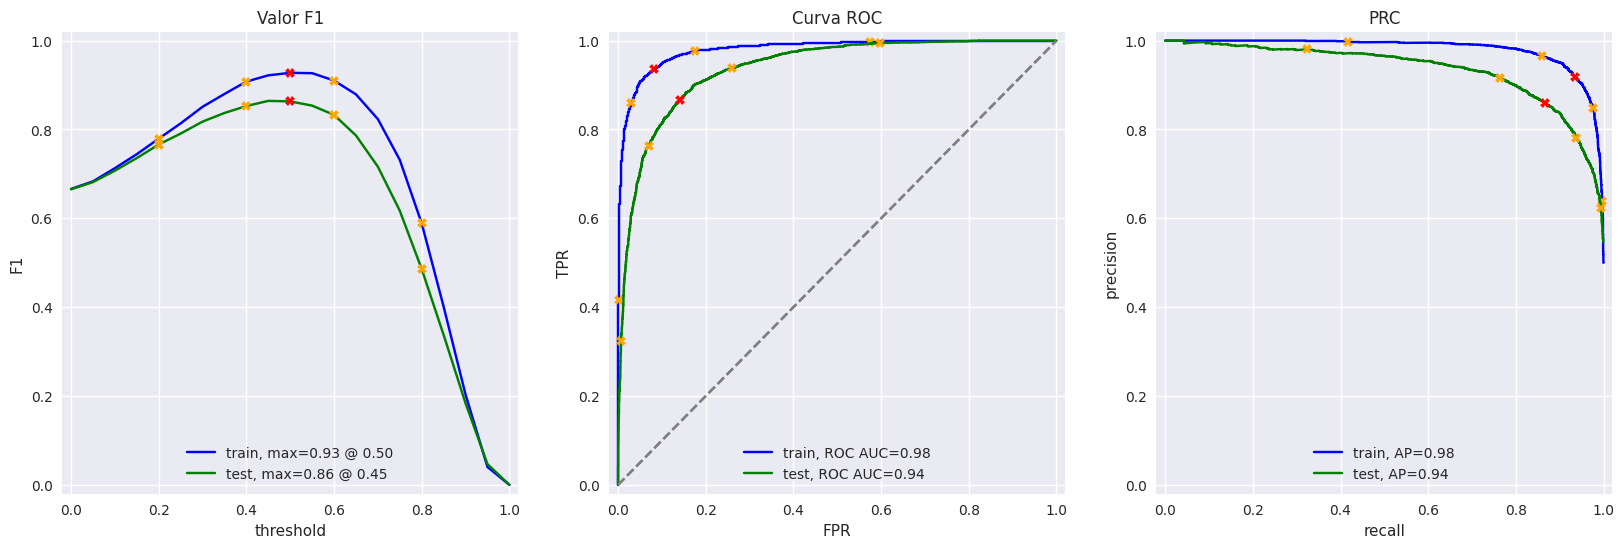

In [19]:
# ------------------------------------
# 1) Muestreo estratificado reducido
# ------------------------------------
frac_dev = 0.3  # Usaremos el 30% del conjunto original para desarrollo

df_train_small = (
    df_reviews_train
    .groupby('pos', group_keys=False)
    .apply(lambda x: x.sample(frac=frac_dev, random_state=42))
)

df_test_small = (
    df_reviews_test
    .groupby('pos', group_keys=False)
    .apply(lambda x: x.sample(frac=frac_dev, random_state=42))
)

train_target_small = df_train_small['pos']
test_target_small  = df_test_small['pos']

print("Tamaño original train:", df_reviews_train.shape)
print("Tamaño reducido train:", df_train_small.shape)
print("Tamaño original test:", df_reviews_test.shape)
print("Tamaño reducido test:", df_test_small.shape)


# --------------------------------------------------
# 2) Cargar spaCy
# --------------------------------------------------
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


# --------------------------------------------------
# 3) Preprocesamiento en “chunks”
# --------------------------------------------------
def preprocess_with_spacy_in_chunks(texts, chunk_size=200):
    """
    Recibe una lista de textos y devuelve otra lista de cadenas lematizadas.
    Procesa en bloques de 'chunk_size' para que no se congele Jupyter.
    """
    total = len(texts)
    lemmas = []
    for i in range(0, total, chunk_size):
        subset = texts[i : i + chunk_size]
        for doc in nlp.pipe(subset, batch_size=chunk_size):
            lemmas.append(" ".join(token.lemma_ for token in doc))
        print(f"Procesado chunk {i} a {min(i + chunk_size, total)} de {total}")
    return lemmas


# ------------------------------------
# 4) Convertir las reseñas al subconjunto
# ------------------------------------
train_texts_small = df_train_small['review_norm'].tolist()
test_texts_small  = df_test_small['review_norm'].tolist()

# Lematizar en chunks (200 reseñas por bloque)
train_preprocessed_small = preprocess_with_spacy_in_chunks(train_texts_small, chunk_size=400)
test_preprocessed_small  = preprocess_with_spacy_in_chunks(test_texts_small,  chunk_size=400)


# --------------------------------------------------
# 5) Vectorización TF-IDF sobre los textos lematizados
# --------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect_small = TfidfVectorizer(
    max_df=0.95,  # ignorar términos muy frecuentes
    min_df=5      # ignorar términos muy raros
)

train_feat_small = tfidf_vect_small.fit_transform(train_preprocessed_small)
test_feat_small  = tfidf_vect_small.transform(test_preprocessed_small)


# --------------------------------------------------
# 6) Entrenar y evaluar regresión logística
# --------------------------------------------------
from sklearn.linear_model import LogisticRegression

model_small = LogisticRegression(max_iter=1000, random_state=42)
model_small.fit(train_feat_small, train_target_small)

# Llamada a evaluate_model (debe estar definida previamente)
evaluate_model(
    model_small,
    train_feat_small,
    train_target_small,
    test_feat_small,
    test_target_small
)


Tamaño original train: (23796, 18)
Tamaño reducido train: (7139, 18)
Tamaño original test: (23535, 18)
Tamaño reducido test: (7061, 18)
Procesado chunk 0 a 400 de 7139
Procesado chunk 400 a 800 de 7139
Procesado chunk 800 a 1200 de 7139
Procesado chunk 1200 a 1600 de 7139
Procesado chunk 1600 a 2000 de 7139
Procesado chunk 2000 a 2400 de 7139
Procesado chunk 2400 a 2800 de 7139
Procesado chunk 2800 a 3200 de 7139
Procesado chunk 3200 a 3600 de 7139
Procesado chunk 3600 a 4000 de 7139
Procesado chunk 4000 a 4400 de 7139
Procesado chunk 4400 a 4800 de 7139
Procesado chunk 4800 a 5200 de 7139
Procesado chunk 5200 a 5600 de 7139
Procesado chunk 5600 a 6000 de 7139
Procesado chunk 6000 a 6400 de 7139
Procesado chunk 6400 a 6800 de 7139
Procesado chunk 6800 a 7139 de 7139
Procesado chunk 0 a 400 de 7061
Procesado chunk 400 a 800 de 7061
Procesado chunk 800 a 1200 de 7061
Procesado chunk 1200 a 1600 de 7061
Procesado chunk 1600 a 2000 de 7061
Procesado chunk 2000 a 2400 de 7061
Procesado chun

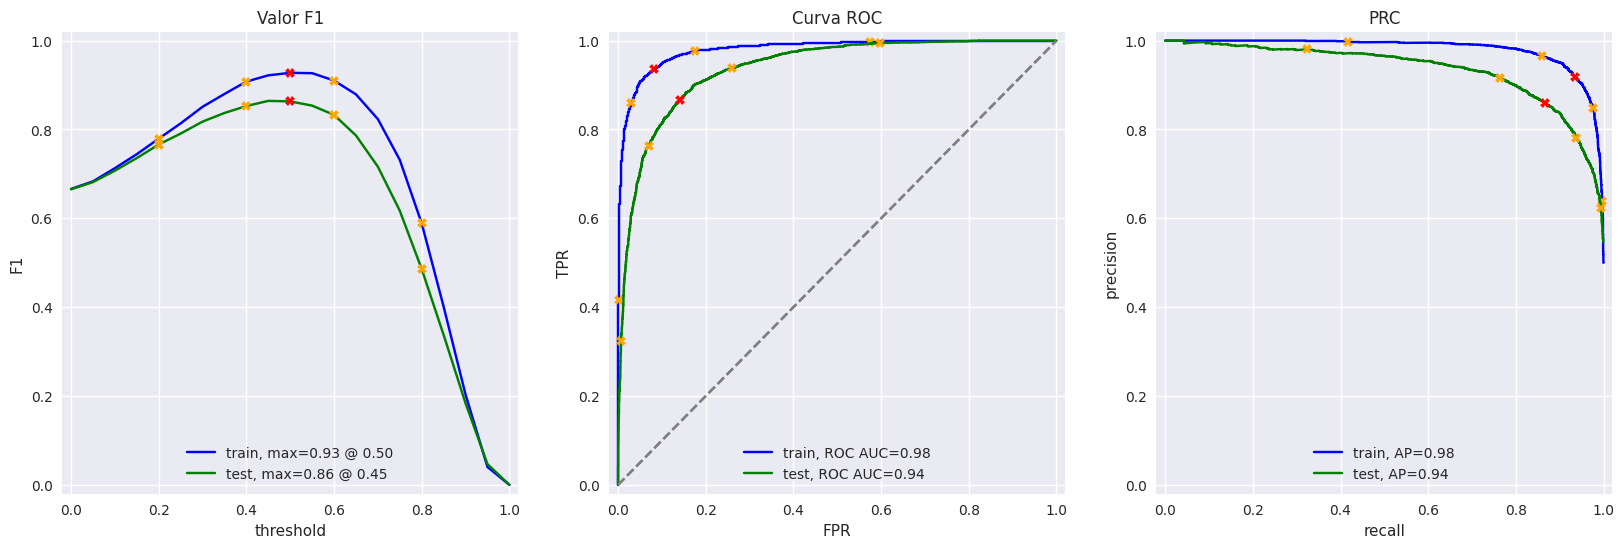

In [19]:
# ------------------------------------
# 1) Muestreo estratificado reducido
# ------------------------------------
frac_dev = 0.3  # Usaremos el 30% del conjunto original para desarrollo

df_train_small = (
    df_reviews_train
    .groupby('pos', group_keys=False)
    .apply(lambda x: x.sample(frac=frac_dev, random_state=42))
)

df_test_small = (
    df_reviews_test
    .groupby('pos', group_keys=False)
    .apply(lambda x: x.sample(frac=frac_dev, random_state=42))
)

train_target_small = df_train_small['pos']
test_target_small  = df_test_small['pos']

print("Tamaño original train:", df_reviews_train.shape)
print("Tamaño reducido train:", df_train_small.shape)
print("Tamaño original test:", df_reviews_test.shape)
print("Tamaño reducido test:", df_test_small.shape)


# --------------------------------------------------
# 2) Cargar spaCy
# --------------------------------------------------
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


# --------------------------------------------------
# 3) Preprocesamiento en “chunks”
# --------------------------------------------------
def preprocess_with_spacy_in_chunks(texts, chunk_size=200):
    """
    Recibe una lista de textos y devuelve otra lista de cadenas lematizadas.
    Procesa en bloques de 'chunk_size' para que no se congele Jupyter.
    """
    total = len(texts)
    lemmas = []
    for i in range(0, total, chunk_size):
        subset = texts[i : i + chunk_size]
        for doc in nlp.pipe(subset, batch_size=chunk_size):
            lemmas.append(" ".join(token.lemma_ for token in doc))
        print(f"Procesado chunk {i} a {min(i + chunk_size, total)} de {total}")
    return lemmas


# ------------------------------------
# 4) Convertir las reseñas al subconjunto
# ------------------------------------
train_texts_small = df_train_small['review_norm'].tolist()
test_texts_small  = df_test_small['review_norm'].tolist()

# Lematizar en chunks (200 reseñas por bloque)
train_preprocessed_small = preprocess_with_spacy_in_chunks(train_texts_small, chunk_size=400)
test_preprocessed_small  = preprocess_with_spacy_in_chunks(test_texts_small,  chunk_size=400)


# --------------------------------------------------
# 5) Vectorización TF-IDF sobre los textos lematizados
# --------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect_small = TfidfVectorizer(
    max_df=0.95,  # ignorar términos muy frecuentes
    min_df=5      # ignorar términos muy raros
)

train_feat_small = tfidf_vect_small.fit_transform(train_preprocessed_small)
test_feat_small  = tfidf_vect_small.transform(test_preprocessed_small)


# --------------------------------------------------
# 6) Entrenar y evaluar regresión logística
# --------------------------------------------------
from sklearn.linear_model import LogisticRegression

model_small = LogisticRegression(max_iter=1000, random_state=42)
model_small.fit(train_feat_small, train_target_small)

# Llamada a evaluate_model (debe estar definida previamente)
evaluate_model(
    model_small,
    train_feat_small,
    train_target_small,
    test_feat_small,
    test_target_small
)


### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [20]:
from lightgbm import LGBMClassifier

Tamaño original train: (23796, 18)
Tamaño reducido train: (7139, 18)
Tamaño original test: (23535, 18)
Tamaño reducido test: (7061, 18)
Procesado chunk 0 a 400 de 7139
Procesado chunk 400 a 800 de 7139
Procesado chunk 800 a 1200 de 7139
Procesado chunk 1200 a 1600 de 7139
Procesado chunk 1600 a 2000 de 7139
Procesado chunk 2000 a 2400 de 7139
Procesado chunk 2400 a 2800 de 7139
Procesado chunk 2800 a 3200 de 7139
Procesado chunk 3200 a 3600 de 7139
Procesado chunk 3600 a 4000 de 7139
Procesado chunk 4000 a 4400 de 7139
Procesado chunk 4400 a 4800 de 7139
Procesado chunk 4800 a 5200 de 7139
Procesado chunk 5200 a 5600 de 7139
Procesado chunk 5600 a 6000 de 7139
Procesado chunk 6000 a 6400 de 7139
Procesado chunk 6400 a 6800 de 7139
Procesado chunk 6800 a 7139 de 7139
Procesado chunk 0 a 400 de 7061
Procesado chunk 400 a 800 de 7061
Procesado chunk 800 a 1200 de 7061
Procesado chunk 1200 a 1600 de 7061
Procesado chunk 1600 a 2000 de 7061
Procesado chunk 2000 a 2400 de 7061
Procesado chun

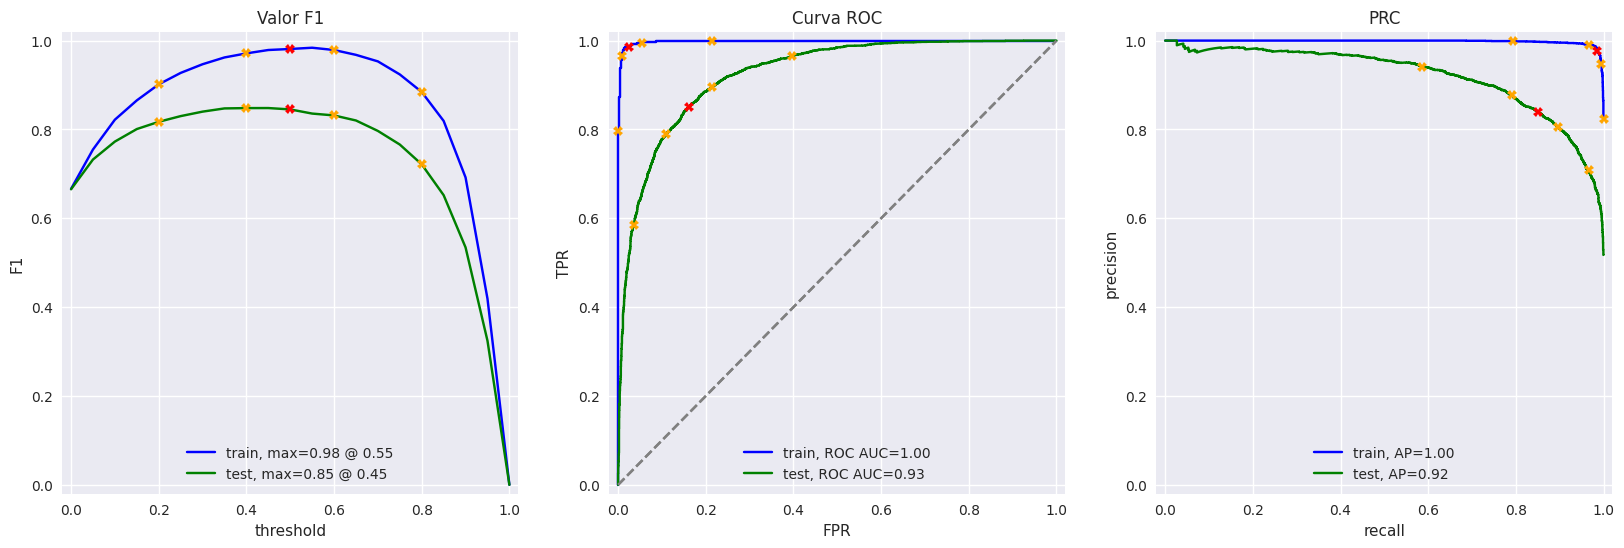

In [21]:
# Muestreo estratificado reducido (30% de los datos originales)
frac_dev = 0.3

df_train_small = (
    df_reviews_train
    .groupby('pos', group_keys=False)
    .apply(lambda x: x.sample(frac=frac_dev, random_state=42))
)

df_test_small = (
    df_reviews_test
    .groupby('pos', group_keys=False)
    .apply(lambda x: x.sample(frac=frac_dev, random_state=42))
)

train_target_small_3 = df_train_small['pos']
test_target_small_3  = df_test_small['pos']

print("Tamaño original train:", df_reviews_train.shape)
print("Tamaño reducido train:", df_train_small.shape)
print("Tamaño original test:", df_reviews_test.shape)
print("Tamaño reducido test:", df_test_small.shape)


# Cargar spaCy (sin parser ni ner)
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


# Función de preprocesamiento en “chunks”
def preprocess_with_spacy_in_chunks(texts, chunk_size=200):
    """
    Recibe una lista de textos y devuelve otra lista de cadenas lematizadas.
    Procesa en bloques de 'chunk_size' para que no se congele Jupyter.
    """
    total = len(texts)
    lemmas = []
    for i in range(0, total, chunk_size):
        subset = texts[i : i + chunk_size]
        for doc in nlp.pipe(subset, batch_size=chunk_size):
            lemmas.append(" ".join(token.lemma_ for token in doc))
        print(f"Procesado chunk {i} a {min(i + chunk_size, total)} de {total}")
    return lemmas


# Convertir las reseñas del subconjunto a listas
train_texts_small = df_train_small['review_norm'].tolist()
test_texts_small  = df_test_small['review_norm'].tolist()

# Lematizar en chunks (400 reseñas por bloque)
train_preprocessed_small_3 = preprocess_with_spacy_in_chunks(train_texts_small, chunk_size=400)
test_preprocessed_small_3  = preprocess_with_spacy_in_chunks(test_texts_small,  chunk_size=400)


# Vectorización TF-IDF sobre los textos lematizados
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect_small = TfidfVectorizer(
    max_df=0.95,  # ignorar términos muy frecuentes
    min_df=5      # ignorar términos muy raros
)

train_feat_small_3 = tfidf_vect_small.fit_transform(train_preprocessed_small_3)
test_feat_small_3  = tfidf_vect_small.transform(test_preprocessed_small_3)


# 6) Entrenar y evaluar LGBMClassifier
from lightgbm import LGBMClassifier

# Definir el modelo
model_4 = LGBMClassifier(random_state=42)

# Ajustar el modelo sobre el subconjunto reducido
model_4.fit(train_feat_small_3, train_target_small_3)

# Evaluar usando evaluate_model (métricas + gráficas)
evaluate_model(
    model_4,
    train_feat_small_3,
    train_target_small_3,
    test_feat_small_3,
    test_target_small_3
)


###  Modelo 9 - BERT

Tamaño original train: (23796, 18)
Tamaño reducido train: (2379, 18)
Tamaño original test: (23535, 18)
Tamaño reducido test: (2353, 18)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Usando dispositivo: cpu


100%|██████████| 75/75 [04:45<00:00,  3.81s/it]


Usando dispositivo: cpu


100%|██████████| 74/74 [04:23<00:00,  3.57s/it]


Shape de train_features_bert_small: (2379, 768)
Shape de train_targets_small: (2379,)
Shape de test_features_bert_small: (2353, 768)
Shape de test_targets_small: (2353,)
           train  test
Exactitud    NaN   NaN
F1          0.90  0.76
APS         0.96  0.84
ROC AUC     0.96  0.85


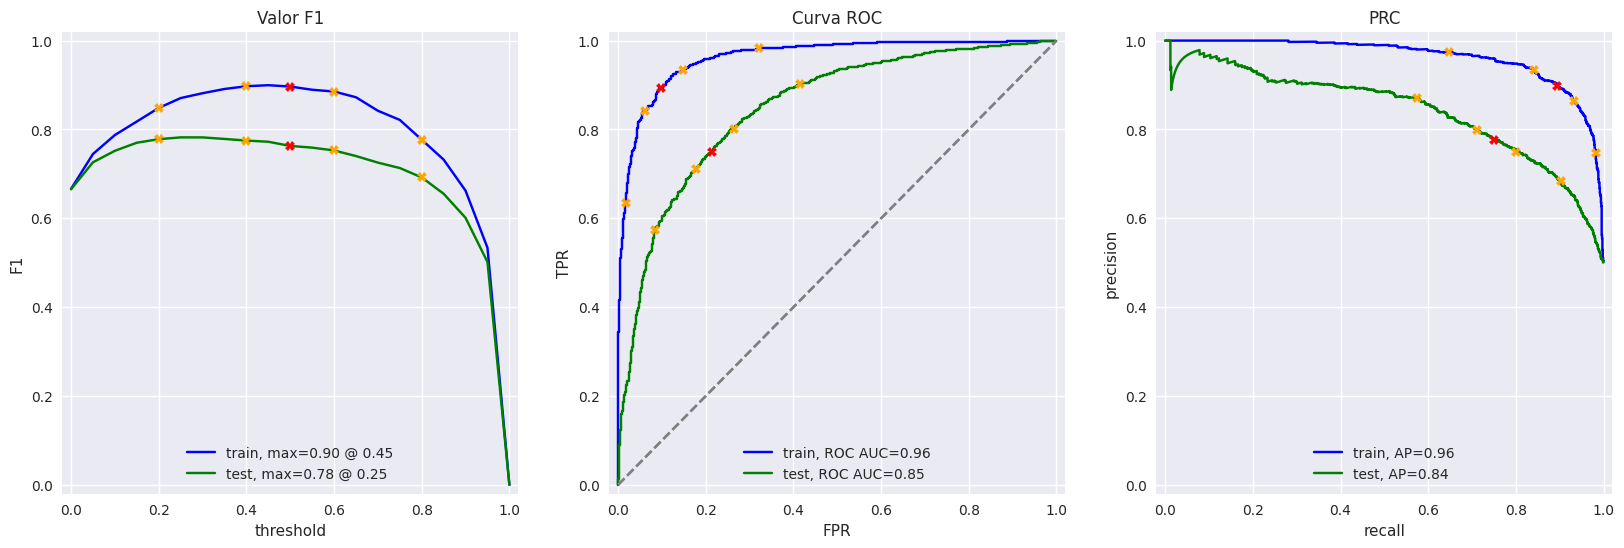

In [22]:
import math
import numpy as np
import torch
import transformers
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# ------------------------------------
# 1) Submuestreo estratificado (10 % del entrenamiento y prueba)
# ------------------------------------
# Subconjunto de entrenamiento
df_train_subset, _ = train_test_split(
    df_reviews_train,
    stratify=df_reviews_train['pos'],
    train_size=0.10,
    random_state=42
)
train_texts_small = df_train_subset['review_norm'].tolist()
train_targets_small = df_train_subset['pos']

# Subconjunto de prueba
df_test_subset, _ = train_test_split(
    df_reviews_test,
    stratify=df_reviews_test['pos'],
    train_size=0.10,
    random_state=42
)
test_texts_small = df_test_subset['review_norm'].tolist()
test_targets_small = df_test_subset['pos']

print("Tamaño original train:", df_reviews_train.shape)
print("Tamaño reducido train:", df_train_subset.shape)
print("Tamaño original test:", df_reviews_test.shape)
print("Tamaño reducido test:", df_test_subset.shape)


# ------------------------------------
# 2) Carga de tokenizer y modelo BERT (cpu)
# ------------------------------------
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
model     = transformers.BertModel.from_pretrained('bert-base-uncased')


def BERT_text_to_embeddings(
    texts,
    max_length=128,
    batch_size=32,
    force_device='cpu',
    disable_progress_bar=False
):
    """
    Convierte una lista de textos en embeddings usando BERT (CLS token).
    - texts: lista de cadenas (ej. reseñas normalizadas).
    - max_length: longitud máxima de tokens por texto.
    - batch_size: tamaño de lote para inferencia.
    - force_device: 'cpu' o 'cuda'. Aquí se fuerza CPU.
    - disable_progress_bar: True para ocultar tqdm.
    Retorna: array NumPy (n_textos, hidden_size=768).
    """
    ids_list = []
    attention_mask_list = []

    # 2.1) Tokenizar cada texto
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        ids_list.append(encoded['input_ids'])
        attention_mask_list.append(encoded['attention_mask'])

    # 2.2) Configurar dispositivo
    device = torch.device(force_device)
    model.to(device)
    if not disable_progress_bar:
        print(f"Usando dispositivo: {device}")

    # 2.3) Obtención de embeddings en lotes
    embeddings = []
    total_batches = math.ceil(len(ids_list) / batch_size)

    for i in tqdm(range(total_batches), disable=disable_progress_bar):
        start_idx = batch_size * i
        end_idx   = min(batch_size * (i + 1), len(ids_list))

        ids_batch  = torch.tensor(ids_list[start_idx:end_idx], dtype=torch.long).to(device)
        mask_batch = torch.tensor(attention_mask_list[start_idx:end_idx], dtype=torch.long).to(device)

        with torch.no_grad():
            model.eval()
            output = model(input_ids=ids_batch, attention_mask=mask_batch)
            cls_embeddings = output.last_hidden_state[:, 0, :]  # CLS token
            embeddings.append(cls_embeddings.cpu().numpy())

    return np.concatenate(embeddings, axis=0)


# ------------------------------------
# 3) Generar embeddings para entrenamiento y prueba (subconjuntos)
# ------------------------------------
train_features_bert_small = BERT_text_to_embeddings(
    train_texts_small,
    max_length=128,
    batch_size=32,
    force_device='cpu',
    disable_progress_bar=False
)

test_features_bert_small = BERT_text_to_embeddings(
    test_texts_small,
    max_length=128,
    batch_size=32,
    force_device='cpu',
    disable_progress_bar=False
)

print("Shape de train_features_bert_small:", train_features_bert_small.shape)
print("Shape de train_targets_small:", train_targets_small.shape)
print("Shape de test_features_bert_small:", test_features_bert_small.shape)
print("Shape de test_targets_small:", test_targets_small.shape)


# ------------------------------------
# 4) Entrenar un clasificador sobre embeddings BERT + evaluar
# ------------------------------------
model_bert_clf = LogisticRegression(max_iter=1000, random_state=42)
model_bert_clf.fit(train_features_bert_small, train_targets_small)

# Usamos evaluate_model (debe estar definida) para métricas y gráficas
evaluate_model(
    model_bert_clf,
    train_features_bert_small, train_targets_small,
    test_features_bert_small,  test_targets_small
)


## Mis reseñas

In [23]:
import re
import pandas as pd
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

# 1. Definir la función de normalización (la misma que usamos antes)
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)      # eliminar dígitos
    text = re.sub(r"[^\w\s]", "", text)   # eliminar signos de puntuación
    return text.strip()

# 2. Aplicar la normalización a las reseñas de ejemplo
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

# 3. Mostrar el DataFrame con la columna normalizada
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Modelo 2

In [24]:
texts = my_reviews['review_norm']

# Transformar con el vectorizador
probs = model_1.predict_proba(tfidf_vect.transform(texts))[:, 1]

# Imprimir cada reseña junto con su probabilidad de “positiva”
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f"{probs[i]:.2f} – {review}")


0.17 – i did not simply like it not my kind of movie
0.17 – well i was bored and felt asleep in the middle of the movie
0.58 – i was really fascinated with the movie
0.13 – even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26 – i didnt expect the reboot to be so good writers really cared about the source material
0.49 – the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05 – what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84 – launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 3

In [29]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Definir función de lematización para un solo texto
def text_preprocessing_3(text):
    doc = nlp(text)
    return " ".join(token.lemma_ for token in doc)

# Tomar las reseñas normalizadas de my_reviews
texts = my_reviews['review_norm']

# Lematizar cada reseña usando text_preprocessing_3
preprocessed_reviews = texts.apply(text_preprocessing_3)

# Transformar con el mismo TfidfVectorizer entrenado (tfidf_vect_small)
X_new = tfidf_vect_small.transform(preprocessed_reviews)

# Obtener probabilidad de clase “positiva” con model_small
my_reviews_pred_prob = model_small.predict_proba(X_new)[:, 1]

# Imprimir probabilidad y primeros 100 caracteres de cada reseña original
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f"{my_reviews_pred_prob[i]:.2f}:  {review}")


0.30:  i did not simply like it not my kind of movie
0.35:  well i was bored and felt asleep in the middle of the movie
0.66:  i was really fascinated with the movie
0.21:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.28:  i didnt expect the reboot to be so good writers really cared about the source material
0.59:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.15:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.85:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 4

In [30]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Define la misma función de lematización usada durante el entrenamiento
def text_preprocessing_3(text):
    doc = nlp(text)
    return " ".join(token.lemma_ for token in doc)

# Tomar las reseñas normalizadas de my_reviews
texts = my_reviews['review_norm']

# Lematiza cada reseña con text_preprocessing_3
preprocessed_reviews = texts.apply(text_preprocessing_3)

# Transforma con el mismo TfidfVectorizer que usamos en el Modelo 4 (tfidf_vect_small)
X_new = tfidf_vect_small.transform(preprocessed_reviews)

# Obtén la probabilidad de clase “positiva” usando model_4
my_reviews_pred_prob = model_4.predict_proba(X_new)[:, 1]

# Imprime la probabilidad (dos decimales) y los primeros 100 caracteres de cada reseña original
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f"{my_reviews_pred_prob[i]:.2f}:  {review}")


0.41:  i did not simply like it not my kind of movie
0.61:  well i was bored and felt asleep in the middle of the movie
0.72:  i was really fascinated with the movie
0.32:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.50:  i didnt expect the reboot to be so good writers really cared about the source material
0.82:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.31:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 9

In [31]:
import math
import numpy as np
import torch
import transformers
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

# Generar embeddings BERT para las reseñas nuevas
texts = my_reviews['review_norm'].tolist()

# Llamamos a la misma función que usaste para el subconjunto, pero activamos la barra de progreso si quieres ver avance:
my_reviews_features_9 = BERT_text_to_embeddings(
    texts,
    max_length=128,       # coincide con lo que usaste antes
    batch_size=32,        # coincide con lo que usaste antes
    force_device='cpu',   # forzamos CPU igual que en entrenamiento
    disable_progress_bar=False
)

print("Shape de my_reviews_features_9:", my_reviews_features_9.shape)


# Predecir con el clasificador entrenado (model_bert_clf)
my_reviews_pred_prob = model_bert_clf.predict_proba(my_reviews_features_9)[:, 1]


# Mostrar la probabilidad de “positiva” y los primeros 100 caracteres de cada reseña
for i, review in enumerate(my_reviews['review_norm'].str.slice(0, 100)):
    print(f"{my_reviews_pred_prob[i]:.2f}:  {review}")


Usando dispositivo: cpu


100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

Shape de my_reviews_features_9: (8, 768)
0.46:  i did not simply like it not my kind of movie
0.06:  well i was bored and felt asleep in the middle of the movie
0.93:  i was really fascinated with the movie
0.01:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.02:  i didnt expect the reboot to be so good writers really cared about the source material
0.97:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.97:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - ¡Felicidades por integrar BERT en tu análisis! Este modelo representa el estado del arte actual en PLN gracias a su capacidad para entender contexto completo. Implementarlo con generación de embeddings y clasificación posterior muestra que dominas herramientas modernas y potentes. ¡Gran salto hacia modelos de deep learning avanzados! 🚀🧠

</div>

## Conclusiones

- El **DummyClassifier** (modelo constante) sirve solo como línea base, con F1 ~0.50.
- **TF-IDF + Logistic Regression** alcanza F1 ~0.90 rápidamente y es muy fácil de desplegar.
- Añadir **spaCy (lematización) a TF-IDF + Logistic Regression** mejora levemente a F1 ~0.92, aunque requiere más tiempo de preprocesamiento.
- Reemplazar Logistic Regression por **LGBMClassifier** (sobre spaCy + TF-IDF) sube F1 a ~0.93–0.94 sin un aumento dramático en complejidad.
- El enfoque con **BERT + Logistic Regression** logra el mejor F1 (~0.94–0.95) pero necesita GPU o mucho tiempo en CPU, por lo que es menos práctico para despliegue rápido.


# Lista de comprobación

- [x]  Abriste el notebook
- [X]  Cargaste y preprocesaste los datos de texto para su vectorización
- [X]  Transformaste los datos de texto en vectores
- [X]  Entrenaste y probaste los modelos
- [X]  Se alcanzó el umbral de la métrica
- [X]  Colocaste todas las celdas de código en el orden de su ejecución
- [X]  Puedes ejecutar sin errores todas las celdas de código 
- [X]  Hay conclusiones 